In [1]:
# Import nesseccary libraries

import os
import random
import math
from collections import Counter
import pandas as pd
import numpy as np
import seaborn as sns
from PIL import Image

import cv2
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET

import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torchvision.models as models
from skimage import io

#   Generate a pandas DataFrame containing image annotations from XML files.


In [2]:
# Generate a pandas DataFrame containing image annotations from XML files
# Define the paths for the images and annotations directories
images_path = Path('images')
anno_path = Path('annotations')

# Define a helper function to generate a list of file paths with a given file type in a directory
def filelist(root, file_type):
    return [os.path.join(directory_path, f) for directory_path, directory_name, 
            files in os.walk(root) for f in files if f.endswith(file_type)]

# Define a function to generate a pandas DataFrame containing image annotations from XML files
def generate_train_df(anno_path):
    # Generate a list of XML annotation file paths
    annotations = filelist(anno_path, '.xml')
    # Initialize an empty list to hold the annotations for each image
    anno_list = []
    # Loop through each XML annotation file
    for anno_path in annotations:
        # Parse the XML file and get the root element
        root = ET.parse(anno_path).getroot()
        # Extract the relevant image annotations and add them to a dictionary
        anno = {}
        anno['filename'] = Path(str(images_path) + '/'+ root.find("./filename").text)
        anno['width'] = root.find("./size/width").text
        anno['height'] = root.find("./size/height").text
        anno['class'] = root.find("./object/name").text
        anno['xmin'] = int(root.find("./object/bndbox/xmin").text)
        anno['ymin'] = int(root.find("./object/bndbox/ymin").text)
        anno['xmax'] = int(root.find("./object/bndbox/xmax").text)
        anno['ymax'] = int(root.find("./object/bndbox/ymax").text)
        # Add the annotation dictionary to the list of annotations
        anno_list.append(anno)
    # Convert the list of annotations to a pandas DataFrame and return it
    return pd.DataFrame(anno_list)

# Read the XML annotations and extract image information


In [3]:
# Store the dataframe as df and view it 
df = generate_train_df(anno_path)
df

,filename,width,height,class,xmin,ymin,xmax,ymax
0,images/road752.png,300,400,speedlimit,60,132,102,175
1,images/road424.png,300,400,speedlimit,57,220,103,265
2,images/road662.png,300,400,speedlimit,77,152,125,199
3,images/road478.png,300,400,speedlimit,114,76,198,160
4,images/road318.png,300,400,crosswalk,68,211,165,307
...,...,...,...,...,...,...,...,...
872,images/road514.png,300,400,speedlimit,176,148,206,177
873,images/road534.png,300,400,crosswalk,14,386,36,399
874,images/road102.png,400,267,speedlimit,37,38,243,245
875,images/road451.png,300,400,speedlimit,97,148,154,203


# Getting additional information about dataset

In [5]:
# Export pre-processed dataset
comp_details = dict(method='zip', archive_name='CAP.csv')
df.to_csv('CAP.zip', index=False, compression=comp_details)

In [6]:
# Read in pre-processed dataset and display first 10 entries
df_train = pd.read_csv('CAP.zip', compression='zip')
df_train.head(10)

,filename,width,height,class,xmin,ymin,xmax,ymax
0,images/road752.png,300,400,speedlimit,60,132,102,175
1,images/road424.png,300,400,speedlimit,57,220,103,265
2,images/road662.png,300,400,speedlimit,77,152,125,199
3,images/road478.png,300,400,speedlimit,114,76,198,160
4,images/road318.png,300,400,crosswalk,68,211,165,307
5,images/road213.png,300,400,speedlimit,88,146,101,159
6,images/road227.png,300,400,speedlimit,141,181,153,193
7,images/road406.png,300,400,speedlimit,111,233,139,260
8,images/road602.png,300,400,speedlimit,88,195,118,225
9,images/road160.png,300,400,crosswalk,180,190,235,248


In [7]:
# Count the number of instances in each class
df_train['class'].value_counts()

speedlimit      652
crosswalk        88
stop             76
trafficlight     61
Name: class, dtype: int64

In [8]:
# Dataframe information
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 877 entries, 0 to 876
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  877 non-null    object
 1   width     877 non-null    int64 
 2   height    877 non-null    int64 
 3   class     877 non-null    object
 4   xmin      877 non-null    int64 
 5   ymin      877 non-null    int64 
 6   xmax      877 non-null    int64 
 7   ymax      877 non-null    int64 
dtypes: int64(6), object(2)
memory usage: 54.9+ KB


In [9]:
# Count of instances in each class
label_group_df=df_train[['filename','class']].groupby(['class']).count().reset_index()
label_group_df.columns=['class','count']
label_group_df=label_group_df.sort_values(by=['count'],ascending=False)
label_group_df

,class,count
1,speedlimit,652
0,crosswalk,88
2,stop,76
3,trafficlight,61


In [10]:
# Number of unique labels
print('Number of unique label groups: ',label_group_df.shape[0])

Number of unique label groups:  4


# Data Visualizations

Here we are showing our images before applying the boundry-box around the specified class. Can be altered between RBG and BGR.

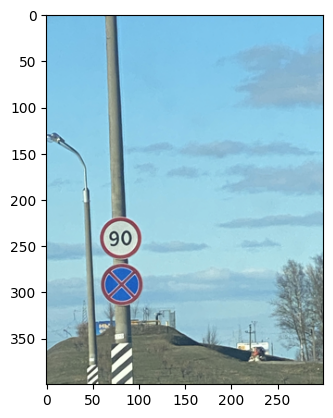

In [11]:
# For loading image
im = cv2.imread(str(df_train.values[1][0]))

# For RBG format
im_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

plt.imshow(im_rgb)

plt.show()

(400, 300, 3)


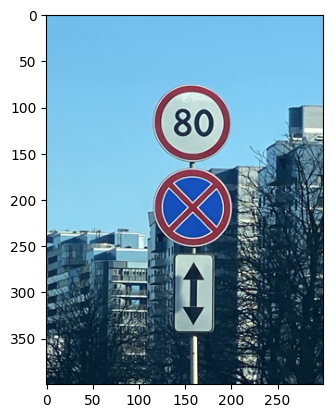

In [12]:
#load in photo
im = cv2.imread(str(df_train.values[3][0]))

# For RBG format
im_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

print(im.shape)

plt.imshow(im_rgb)

(400, 300, 3)


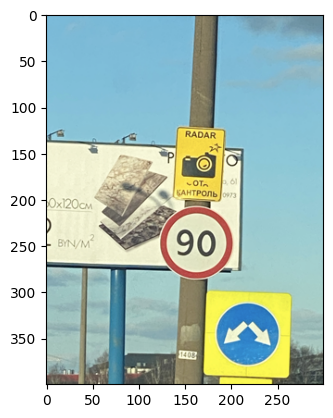

In [13]:
im = cv2.imread(str(df_train.values[199][0]))
print(im.shape)

im_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)


plt.imshow(im_rgb)

(267, 400, 3)


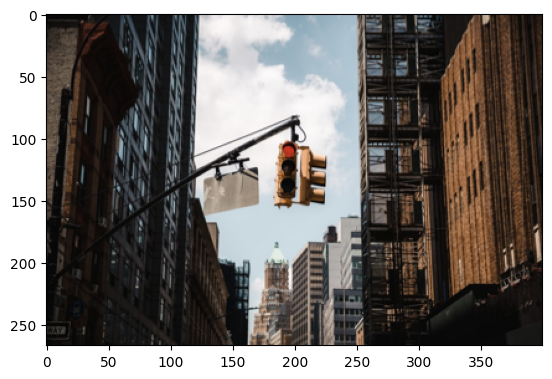

In [14]:
#load in image
im = cv2.imread(str(df_train.values[56][0]))
print(im.shape)

#convert to RGB
im_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)


plt.imshow(im_rgb)

Text(0.5, 1.0, 'Number of Instances In Each Class')

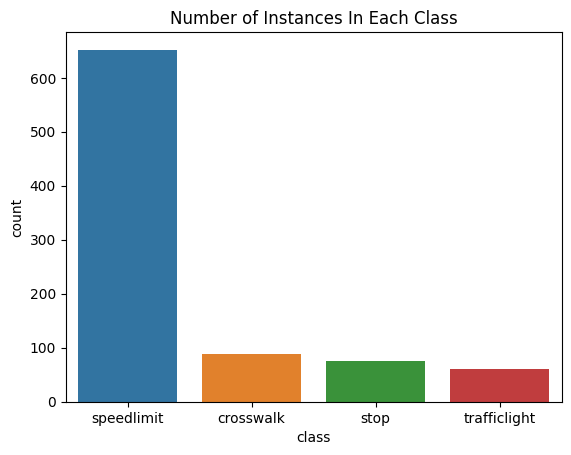

In [15]:
# Barplot of class feature
sns.barplot(x=label_group_df['class'],y=label_group_df['count'])
plt.title('Number of Instances In Each Class')

In [16]:
# Creating dataframes for each class
speedlimit_df = df_train[df_train['class'] == 'speedlimit']
stop_df = df_train[df_train['class'] == 'stop'] 
crosswalk_df = df_train[df_train['class'] == 'crosswalk']
trafficlight_df = df_train[df_train['class'] == 'trafficlight']

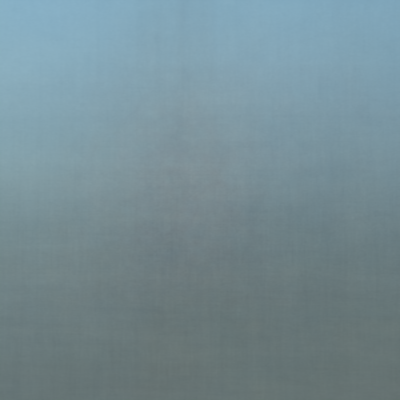

In [17]:
# visualizing Average Image for Speedlimit
w, h = 400, 400  # set a fixed size for all images
N = len(speedlimit_df)

# Create a numpy array of floats to store the average (assume RGB images)
arr = np.zeros((h, w, 3), dtype= float)

# Build up average pixel intensities, casting each image as an array of floats
for i, row in speedlimit_df.iterrows():
    im = Image.open(row['filename'])
    im = im.resize((w, h))  # resize image to the fixed size
    if im.mode == 'RGBA':
        im = im.convert('RGB')  # convert RGBA to RGB
    imarr = np.array(im, dtype= float)
    arr = arr + imarr / N

# Round values in array and cast as 8-bit integer
arr = np.array(np.round(arr), dtype=np.uint8)

# Generate, save and preview final image
out = Image.fromarray(arr, mode='RGB')
out.save('Speed Limit Average.png')
display(out)

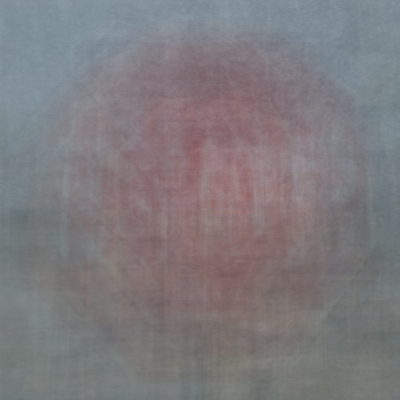

In [18]:
# visualizing Average Image for Stop sign
w, h = 400, 400  # set a fixed size for all images
N = len(stop_df)

# Create a numpy array of floats to store the average (assume RGB images)
arr = np.zeros((h, w, 3), dtype= float)

# Build up average pixel intensities, casting each image as an array of floats
for i, row in stop_df.iterrows():
    im = Image.open(row['filename'])
    im = im.resize((w, h))  # resize image to the fixed size
    if im.mode == 'RGBA':
        im = im.convert('RGB')  # convert RGBA to RGB
    imarr = np.array(im, dtype= float)
    arr = arr + imarr / N

# Round values in array and cast as 8-bit integer
arr = np.array(np.round(arr), dtype=np.uint8)

# Generate, save and preview final image
out = Image.fromarray(arr, mode='RGB')
out.save('Average.png')
display(out)

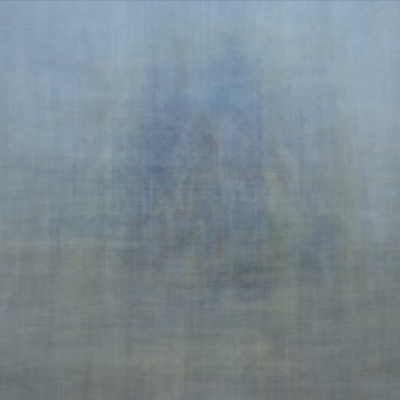

In [19]:
# visualizing Average Image for Crosswalk
w, h = 400, 400  # set a fixed size for all images
N = len(crosswalk_df)

# Create a numpy array of floats to store the average (assume RGB images)
arr = np.zeros((h, w, 3), dtype= float)

# Build up average pixel intensities, casting each image as an array of floats
for i, row in crosswalk_df.iterrows():
    im = Image.open(row['filename'])
    im = im.resize((w, h))  # resize image to the fixed size
    if im.mode == 'RGBA':
        im = im.convert('RGB')  # convert RGBA to RGB
    imarr = np.array(im, dtype= float)
    arr = arr + imarr / N

# Round values in array and cast as 8-bit integer
arr = np.array(np.round(arr), dtype=np.uint8)

# Generate, save and preview final image
out = Image.fromarray(arr, mode='RGB')
out.save('Crosswalk Average.png')
display(out)

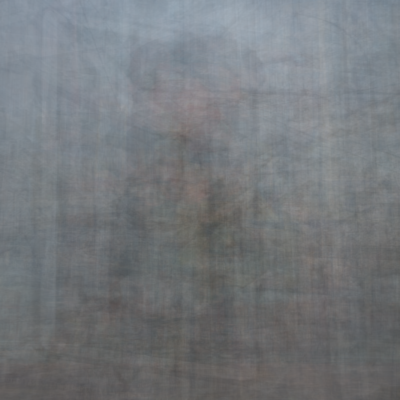

In [20]:
# visualizing Average Image for Traffic Light
w, h = 400, 400  # set a fixed size for all images
N = len(trafficlight_df)

# Create a numpy array of floats to store the average (assume RGB images)
arr = np.zeros((h, w, 3), dtype= float)

# Build up average pixel intensities, casting each image as an array of floats
for i, row in trafficlight_df.iterrows():
    im = Image.open(row['filename'])
    im = im.resize((w, h))  # resize image to the fixed size
    if im.mode == 'RGBA':
        im = im.convert('RGB')  # convert RGBA to RGB
    imarr = np.array(im, dtype= float)
    arr = arr + imarr / N

# Round values in array and cast as 8-bit integer
arr = np.array(np.round(arr), dtype=np.uint8)

# Generate, save and preview final image
out = Image.fromarray(arr, mode='RGB')
out.save('Traffic Light Average.png')
display(out)

Here we are visualizing the color distribution amongst our classes. What these histograms tell is, what colors occur the most surrounding the speified class.

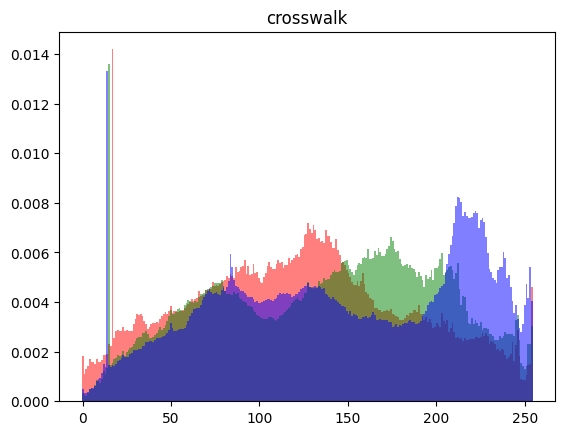

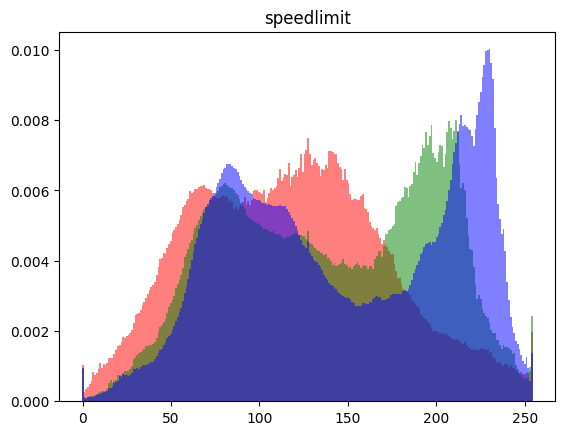

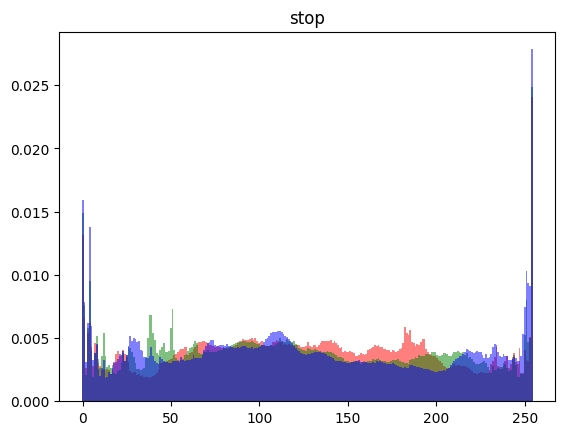

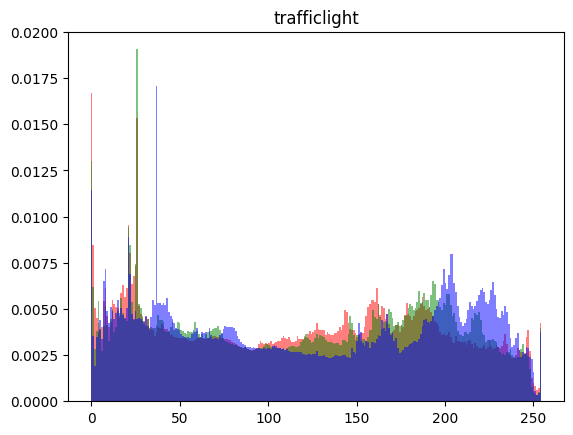

In [21]:
# Group images by class
groups = df_train.groupby('class')

# Compute the range of pixel values across all images
min_value = np.inf
max_value = -np.inf
for i, row in df_train.iterrows():
    im = Image.open(row['filename'])
    arr = np.array(im)
    min_value = min(min_value, arr.min())
    max_value = max(max_value, arr.max())

# Define bin edges for the histograms based on the pixel value range
bin_edges = np.linspace(min_value, max_value, 256+1)

# Loop over each class and plot color histograms for its images
for name, group in groups:
    # Create an empty array to store the histograms
    hist = np.zeros((256, 3))
    
    # Loop over each image and compute its color histogram
    for i, row in group.iterrows():
        im = Image.open(row['filename'])
        arr = np.array(im)
        for j in range(3):  # loop over color channels (R, G, B)
            channel_hist, _ = np.histogram(arr[:,:,j], bins=bin_edges)
            hist[:,j] += channel_hist
    
    # Normalize the histograms and plot them
    hist /= hist.sum(axis=0, keepdims=True)
    plt.figure()
    plt.title(name)
    plt.bar(bin_edges[:-1], hist[:,0], width=np.diff(bin_edges), color='r', alpha=0.5)
    plt.bar(bin_edges[:-1], hist[:,1], width=np.diff(bin_edges), color='g', alpha=0.5)
    plt.bar(bin_edges[:-1], hist[:,2], width=np.diff(bin_edges), color='b', alpha=0.5)
    plt.show()

### Data Preprocessing

In [22]:
# Encode labels of class feature 
class_dict = {'speedlimit': 0, 'stop': 1, 'crosswalk': 2, 'trafficlight': 3}
df_train['class'] = df_train['class'].apply(lambda x:  class_dict[x])

# Show dataframe shape and head
print(df_train.shape)
df_train.head()

(877, 8)


,filename,width,height,class,xmin,ymin,xmax,ymax
0,images/road752.png,300,400,0,60,132,102,175
1,images/road424.png,300,400,0,57,220,103,265
2,images/road662.png,300,400,0,77,152,125,199
3,images/road478.png,300,400,0,114,76,198,160
4,images/road318.png,300,400,2,68,211,165,307


In [23]:
# Export pre-processed dataset
# Save the updated dataframe to a new csv file
compress = dict(method='zip', archive_name='new_data.csv')
df_train.to_csv('new_data.zip', index=False, compression=compress)

In [24]:
# Read in pre-processed dataset and display first 10 entries
df_train = pd.read_csv('new_data.zip', compression='zip')
df_train.head(10)

,filename,width,height,class,xmin,ymin,xmax,ymax
0,images/road752.png,300,400,0,60,132,102,175
1,images/road424.png,300,400,0,57,220,103,265
2,images/road662.png,300,400,0,77,152,125,199
3,images/road478.png,300,400,0,114,76,198,160
4,images/road318.png,300,400,2,68,211,165,307
5,images/road213.png,300,400,0,88,146,101,159
6,images/road227.png,300,400,0,141,181,153,193
7,images/road406.png,300,400,0,111,233,139,260
8,images/road602.png,300,400,0,88,195,118,225
9,images/road160.png,300,400,2,180,190,235,248


# Creating Boundry-box around classes and transforming the image via rotation.

In [25]:
# Define function to read image and convert it to RGB format
def read_image(path):
    return cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_BGR2RGB)

# Define function to create a binary mask based on a bounding box and an image
def create_mask(bb, x):
    # Get the shape of the input image
    rows,cols,*_ = x.shape
    # Create an array of zeros with the same shape as the input image
    Y = np.zeros((rows, cols))
    # Convert the bounding box to integers
    bb = bb.astype(np.int64)
    # Set the values inside the bounding box to 1
    Y[bb[0]:bb[2], bb[1]:bb[3]] = 1.
    return Y

# Define function to convert binary mask to bounding box array
def mask_to_bb(Y):
    # Get the indices of non-zero elements in the input array
    cols, rows = np.nonzero(Y)
    # If there are no non-zero elements, return an array of zeros
    if len(cols) == 0: 
        return np.zeros(4, dtype=np.float32)
    # Calculate the minimum and maximum values of the rows and columns
    top_row = np.min(rows)
    left_col = np.min(cols)
    bottom_row = np.max(rows)
    right_col = np.max(cols)
    # Return the bounding box array with left, top, right, bottom coordinates
    return np.array([left_col, top_row, right_col, bottom_row], dtype=np.float32)

# Define function to create a bounding box array from dataset information
def create_bb_array(x):
    return np.array([x[5],x[4],x[7],x[6]])

# Define function to resize an image and its corresponding bounding box
def resize_image_bb(read_path, write_path, bb, sz):
    # Read the image from the input path and convert it to RGB format
    im = read_image(read_path)
    # Resize the image to the target size
    im_resized = cv2.resize(im, (sz, sz))
    # Resize the binary mask based on the bounding box and resize it to the target size
    Y_resized = cv2.resize(create_mask(bb, im), (sz, sz))
    # Create a new path for the resized image
    new_path = str(write_path/read_path.parts[-1])
    # Save the resized image to the new path
    cv2.imwrite(new_path, cv2.cvtColor(im_resized, cv2.COLOR_RGB2BGR))
    # Return the new path and the bounding box array for the resized mask
    return new_path, mask_to_bb(Y_resized)

In [26]:
# Setting Image Size to 300
IM_SIZE = 300

In [27]:
# Define a list to store new image paths
new_paths = []

# Define a list to store new bounding boxes
new_bbs = []

# Define a path to store resized images
train_path_resized = Path('./images_resized')
# Create the directory if it does not exist
Path.mkdir(train_path_resized, exist_ok=True)


# Iterate through each row of the training data
for index, row in df_train.iterrows():
    read_path = Path(row['filename'])
    new_path,new_bb = resize_image_bb(read_path, train_path_resized, create_bb_array(row.values), IM_SIZE)
    new_paths.append(new_path)
    new_bbs.append(new_bb)
    
# Add the new paths and bounding boxes to df_train dataframe    
df_train['new_path'] = new_paths
df_train['new_bb'] = new_bbs

# Display the first few rows of the updated df_train
df_train.head(100)

,filename,width,height,class,xmin,ymin,xmax,ymax,new_path,new_bb
0,images/road752.png,300,400,0,60,132,102,175,images_resized/road752.png,"[99.0, 60.0, 131.0, 101.0]"
1,images/road424.png,300,400,0,57,220,103,265,images_resized/road424.png,"[165.0, 57.0, 198.0, 102.0]"
2,images/road662.png,300,400,0,77,152,125,199,images_resized/road662.png,"[114.0, 77.0, 149.0, 124.0]"
3,images/road478.png,300,400,0,114,76,198,160,images_resized/road478.png,"[57.0, 114.0, 119.0, 197.0]"
4,images/road318.png,300,400,2,68,211,165,307,images_resized/road318.png,"[158.0, 68.0, 230.0, 164.0]"
...,...,...,...,...,...,...,...,...,...,...
95,images/road675.png,300,400,0,22,217,31,226,images_resized/road675.png,"[162.0, 22.0, 169.0, 30.0]"
96,images/road540.png,300,400,0,145,271,183,309,images_resized/road540.png,"[203.0, 145.0, 231.0, 182.0]"
97,images/road459.png,300,400,0,111,142,177,210,images_resized/road459.png,"[106.0, 111.0, 157.0, 176.0]"
98,images/road159.png,300,400,0,155,148,229,225,images_resized/road159.png,"[111.0, 155.0, 168.0, 228.0]"


In [28]:
# A function that crops an image based on the input parameters
def crop(im, r, c, target_r, target_c): 
    return im[r:r+target_r, c:c+target_c]

# A function performs center cropping of an image
def center_crop(x, r_pix=8):
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    return crop(x, r_pix, c_pix, r-2*r_pix, c-2*c_pix)

# A function to rotate an image by a given degree
def rotate_cv(im, deg, y=False, mode=cv2.BORDER_REFLECT):
    r, c, *_ = im.shape
    M = cv2.getRotationMatrix2D((c/2, r/2), deg, 2)
    return cv2.warpAffine(im, M, (c, r), borderMode=mode, flags=cv2.WARP_FILL_OUTLIERS)

# A function to randomly crops images and its corresponding mask
def random_cropXY(x, Y, r_pix=8):
  
    r, c,*_ = x.shape
    c_pix = round(r_pix * c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2 * rand_r * r_pix).astype(np.int64)
    start_c = np.floor(2 * rand_c * c_pix).astype(np.int64)
    xx = crop(x, start_r, start_c, r - 2*r_pix, c - 2*c_pix)
    YY = crop(Y, start_r, start_c, r - 2*r_pix, c - 2*c_pix)
    return xx, YY

# A function to apply transforms to the image and its corresponding mask
def transformsXY(path, bb, is_transforms):
    x = cv2.imread(str(path)).astype(np.float32)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB) / 255
    Y = create_mask(bb, x)
    if is_transforms:
        rdeg = (np.random.random()-.50) * 20
        x = rotate_cv(x, rdeg)
        Y = rotate_cv(Y, rdeg, y=True)
        if np.random.random() > 0.5: 
            x = np.fliplr(x).copy()
            Y = np.fliplr(Y).copy()
        x, Y = random_cropXY(x, Y)
    else:
        x, Y = center_crop(x), center_crop(Y)
    return x, mask_to_bb(Y)

# This function creates a rectangle object based on the input bounding box coordinates
def create_corner_rect(bb, color='red'):
    bb = np.array(bb, dtype=np.float32)
    return plt.Rectangle((bb[1], bb[0]), bb[3]-bb[1], bb[2]-bb[0], color=color,
                         fill=False, lw=3)

# This function shows an image with its corresponding bounding box overlay
def show_corner_bb(im, bb):
    plt.imshow(im)
    plt.gca().add_patch(create_corner_rect(bb))

images_resized/road401.png


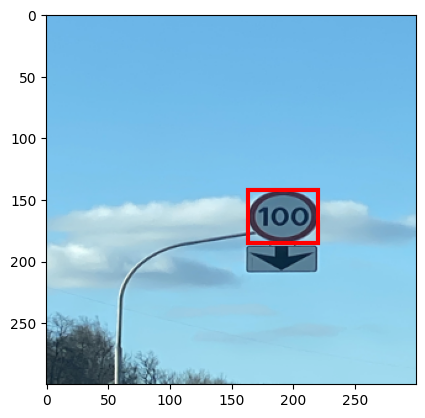

In [29]:
number = 690
im = cv2.imread(str(df_train['new_path'].values[number]))
print(str(df_train.values[number][8]))
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
show_corner_bb(im, df_train['new_bb'].values[number])

We first crop the photo and then we apply the rotation transformation.

images_resized/road21.png


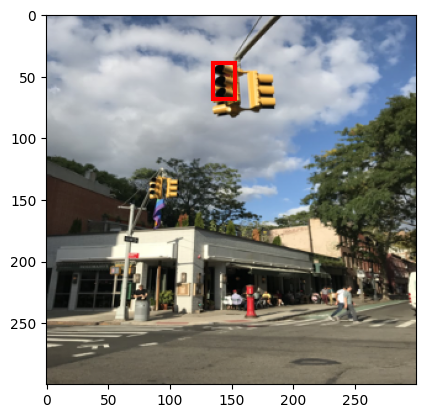

In [30]:
number = 77
im = cv2.imread(str(df_train['new_path'].values[number]))
print(str(df_train.values[number][8]))
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
show_corner_bb(im, df_train['new_bb'].values[number])

images_resized/road21.png


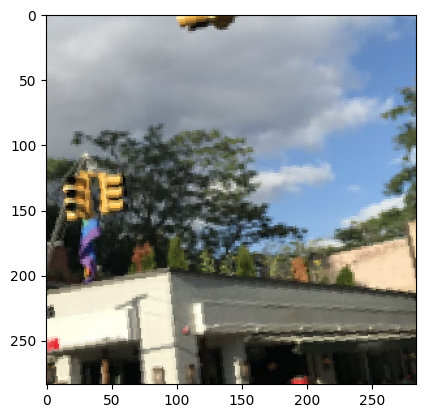

In [31]:
im, bb = transformsXY(str(df_train['new_path'].values[number]),
                      df_train['new_bb'].values[number],
                      is_transforms=True)
show_corner_bb(im, bb)
print(str(df_train.values[number][8]))

In [32]:
# Export pre-processed dataset
# Save the updated dataframe to a new csv file
compress = dict(method='zip', archive_name='updated_data.csv')
df_train.to_csv('updated_data.zip', index=False, compression=compress)

In [33]:
# Read in pre-processed dataset and display first 10 entries
df_train = pd.read_csv('updated_data.zip', compression='zip')
df_train.head(10)

,filename,width,height,class,xmin,ymin,xmax,ymax,new_path,new_bb
0,images/road752.png,300,400,0,60,132,102,175,images_resized/road752.png,[ 99. 60. 131. 101.]
1,images/road424.png,300,400,0,57,220,103,265,images_resized/road424.png,[165. 57. 198. 102.]
2,images/road662.png,300,400,0,77,152,125,199,images_resized/road662.png,[114. 77. 149. 124.]
3,images/road478.png,300,400,0,114,76,198,160,images_resized/road478.png,[ 57. 114. 119. 197.]
4,images/road318.png,300,400,2,68,211,165,307,images_resized/road318.png,[158. 68. 230. 164.]
5,images/road213.png,300,400,0,88,146,101,159,images_resized/road213.png,[109. 88. 119. 100.]
6,images/road227.png,300,400,0,141,181,153,193,images_resized/road227.png,[135. 141. 144. 152.]
7,images/road406.png,300,400,0,111,233,139,260,images_resized/road406.png,[174. 111. 194. 138.]
8,images/road602.png,300,400,0,88,195,118,225,images_resized/road602.png,[146. 88. 168. 117.]
9,images/road160.png,300,400,2,180,190,235,248,images_resized/road160.png,[142. 180. 185. 234.]


# Classifying images with CNN

In [34]:
class Roadsigns(torch.utils.data.Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)
        label = torch.tensor(int(self.annotations.iloc[index, 3]))
        return image, label

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# hyperparameters
in_channel = 3
learning_rate = 1e-3
batch_size = 32
num_epochs = 100

# load data 
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
dataset = Roadsigns(csv_file='updated_data.zip', root_dir='' , transform=transform)

train_set, test_set = torch.utils.data.random_split(dataset, [600, 277])
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=True)

# Calculate class weights
num_classes = 4
num_samples_per_class = [len(dataset.annotations[dataset.annotations['class'] == i]) for i in range(num_classes)]
class_weight = torch.Tensor([1/num_samples_per_class[i] for i in range(num_classes)])

model = torchvision.models.googlenet(weights= 'GoogLeNet_Weights.DEFAULT')
model.fc = nn.Linear(1024, 4)
model.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weight.to(device))
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_loss = []
train_acc = []
test_loss = []
test_acc = []

for epoch in range(num_epochs):
    losses = []
    train_correct = 0
    train_total = 0
    
    for batch_idx, (data,targets) in enumerate(train_loader):
        data = data.to(device=device)
        targets = targets.to(device=device)
        
        scores = model(data)
        loss = criterion(scores,targets)
        
        losses.append(loss.item())
        
        #backward
        optimizer.zero_grad()
        loss.backward()
        
        # gradient descent or adam step
        optimizer.step()
        
        # calculate accuracy
        _, predicted = torch.max(scores.data, 1)
        train_total += targets.size(0)
        train_correct += (predicted == targets).sum().item()
    
    train_loss.append(sum(losses)/len(losses))
    train_acc.append(train_correct/train_total)
    
    test_correct = 0
    test_total = 0
    test_losses = []
    with torch.no_grad():
        for data,targets in test_loader:
            data = data.to(device=device)
            targets = targets.to(device=device)

            scores = model(data)
            loss = criterion(scores, targets)
            test_losses.append(loss.item())

            _, predicted = torch.max(scores.data, 1)
            test_total += targets.size(0)
            test_correct += (predicted == targets).sum().item()
            
    test_loss.append(sum(test_losses)/len(test_losses))
    test_acc.append(test_correct/test_total)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss[-1]:.4f}, Test Loss: {test_loss[-1]:.4f}, Train Accuracy: {train_acc[-1]:.4f}, Test Accuracy: {test_acc[-1]:.4f}')

def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x,y in loader:
            x = x.to(device=device)
            y = y.to(device=device)
            
            scores = model(x)
            _, prediction = scores.max(1)
            num_correct += (prediction == y).sum()
            num_samples += prediction.size(0)
        
        accuracy = float(num_correct)/float(num_samples)*100
        print(f"Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}%")

Epoch [1/100], Train Loss: 0.7460, Test Loss: 0.4876, Train Accuracy: 0.6850, Test Accuracy: 0.8412
Epoch [2/100], Train Loss: 0.3778, Test Loss: 0.4857, Train Accuracy: 0.9150, Test Accuracy: 0.8917
Epoch [3/100], Train Loss: 0.2944, Test Loss: 0.5359, Train Accuracy: 0.8983, Test Accuracy: 0.8881
Epoch [4/100], Train Loss: 0.1657, Test Loss: 0.6519, Train Accuracy: 0.9617, Test Accuracy: 0.9025
Epoch [5/100], Train Loss: 0.0645, Test Loss: 0.7263, Train Accuracy: 0.9667, Test Accuracy: 0.9025
Epoch [6/100], Train Loss: 0.1150, Test Loss: 0.7470, Train Accuracy: 0.9667, Test Accuracy: 0.9025
Epoch [7/100], Train Loss: 0.1076, Test Loss: 0.8757, Train Accuracy: 0.9567, Test Accuracy: 0.9134
Epoch [8/100], Train Loss: 0.2068, Test Loss: 0.8744, Train Accuracy: 0.9550, Test Accuracy: 0.8484
Epoch [9/100], Train Loss: 0.3106, Test Loss: 0.7762, Train Accuracy: 0.9117, Test Accuracy: 0.8303
Epoch [10/100], Train Loss: 0.2255, Test Loss: 1.1602, Train Accuracy: 0.9050, Test Accuracy: 0.8881

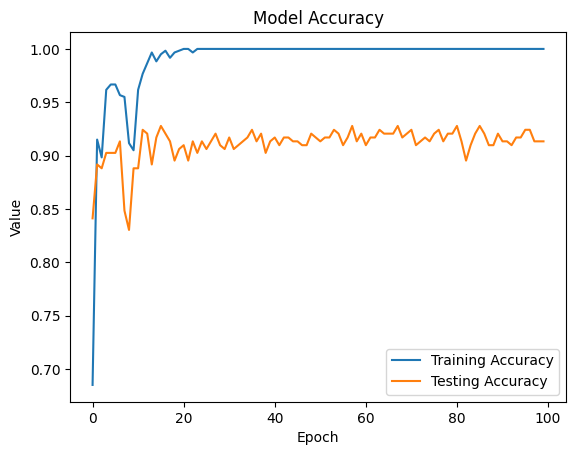

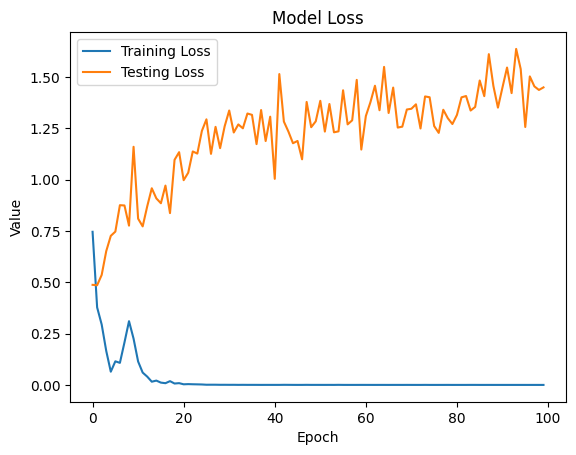

In [35]:
# plot training and testing accuracy
plt.plot(train_acc, label='Training Accuracy')
plt.plot(test_acc, label='Testing Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.show()

# plot training and testing loss
plt.plot(train_loss, label='Training Loss')
plt.plot(test_loss, label='Testing Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.show()

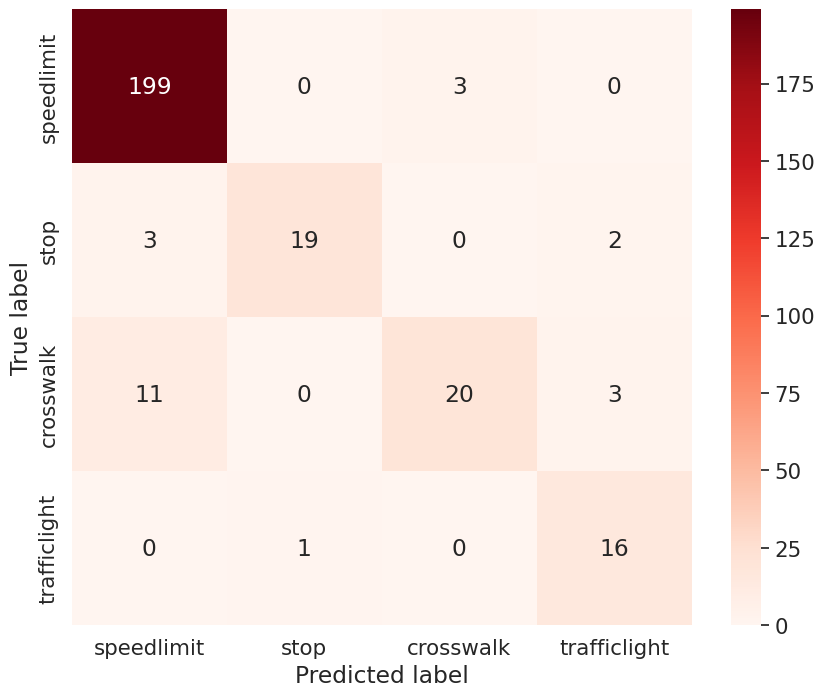

In [36]:
from sklearn.metrics import confusion_matrix

# get the predictions on a test set
model.eval()
with torch.no_grad():
    predictions = []
    true_labels = []
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        logits = model(images)
        preds = torch.argmax(logits, dim=1)
        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# create the confusion matrix
cm = confusion_matrix(true_labels, predictions)

# plot the confusion matrix using seaborn
classes = ['speedlimit', 'stop', 'crosswalk', 'trafficlight']
sns.set(font_scale=1.4)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g', cmap='Reds', xticklabels=classes, yticklabels=classes)

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [37]:
from sklearn.metrics import classification_report

# Get the predicted labels from the model
y_pred = model(images).argmax(dim=1)

# Move the labels tensor to the CPU and convert to numpy array
y_true = labels.cpu().numpy()
y_pred = y_pred.cpu().numpy()

report = classification_report(y_true, y_pred, target_names=classes)

# Print the classification report
print(report)

              precision    recall  f1-score   support

  speedlimit       0.92      1.00      0.96        12
        stop       1.00      1.00      1.00         2
   crosswalk       1.00      0.80      0.89         5
trafficlight       1.00      1.00      1.00         2

    accuracy                           0.95        21
   macro avg       0.98      0.95      0.96        21
weighted avg       0.96      0.95      0.95        21



## Start an MLflow run to log the hyperparameters, metrics, and artifacts

In [41]:
import json
import mlflow
import logging

logging.getLogger("mlflow").setLevel(logging.ERROR)

# Enable autolog()
mlflow.sklearn.autolog()

In [42]:
with mlflow.start_run():
    
    # Log hyperparameters
    mlflow.log_param('learning_rate', learning_rate)
    mlflow.log_param('batch_size', batch_size)
    mlflow.log_param('num_epochs', num_epochs)

    # Log the model architecture as a JSON string
    mlflow.log_text(json.dumps(model_architecture), 'model_architecture.json')

    # Log the class weight as a JSON string
    mlflow.log_text(json.dumps(class_weight.tolist()), 'class_weight.json')

    # Set optimizer and criterion as tags
    mlflow.set_tag('optimizer', 'Adam')
    mlflow.set_tag('criterion', 'CrossEntropyLoss')

    # Train and log metrics
    for epoch in range(num_epochs):
        losses = []
        
        for batch_idx, (data,targets) in enumerate(train_loader):
            data = data.to(device=device)
            targets = targets.to(device=device)
            
            scores = model(data)
            loss = criterion(scores,targets)
            
            losses.append(loss.item())
            
            #backward
            optimizer.zero_grad()
            loss.backward()
            
            # gradient descent or adam step
            optimizer.step()
        
        train_loss = sum(losses)/len(losses)
        mlflow.log_metric('train_loss', train_loss, epoch)
        
        # Check accuracy on Training Set
        train_acc, train_samples = check_accuracy(train_loader, model)
        mlflow.log_metric('train_accuracy', train_acc/train_samples, epoch)
        
        # Checking accuracy on Test set
        test_acc, test_samples = check_accuracy(test_loader, model)
        mlflow.log_metric('test_accuracy', test_acc/test_samples, epoch)